# Storm Data Prediciton
## Group 1: Dhairya Dodia, Duncan Conley, Jameson Thomas
----------------------------------------------------------

### Step 0: Import libraries:

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

### Step 1: Load & Prep Data

      BEGIN_DATE_TIME       END_DATE_TIME  ELAPSED_TIME_MIN
1  16-NOV-24 02:30:00  18-NOV-24 14:21:00              3591
2  19-MAY-24 18:39:00  19-MAY-24 19:02:00                23
3  23-MAY-24 21:55:00  23-MAY-24 21:55:00                 0
4  24-MAY-24 14:05:00  24-MAY-24 14:10:00                 5
5  01-NOV-24 00:00:00  01-NOV-24 16:00:00               960
NaNs in X after imputation: False
NaNs in X_train: False
NaNs in X_test: False
Accuracy: 0.9037637838330448
Classification Report:
               precision    recall  f1-score   support

        high       0.20      0.16      0.18       172
         low       0.95      0.96      0.95     10204
      medium       0.25      0.22      0.23       597

    accuracy                           0.90     10973
   macro avg       0.46      0.45      0.45     10973
weighted avg       0.90      0.90      0.90     10973



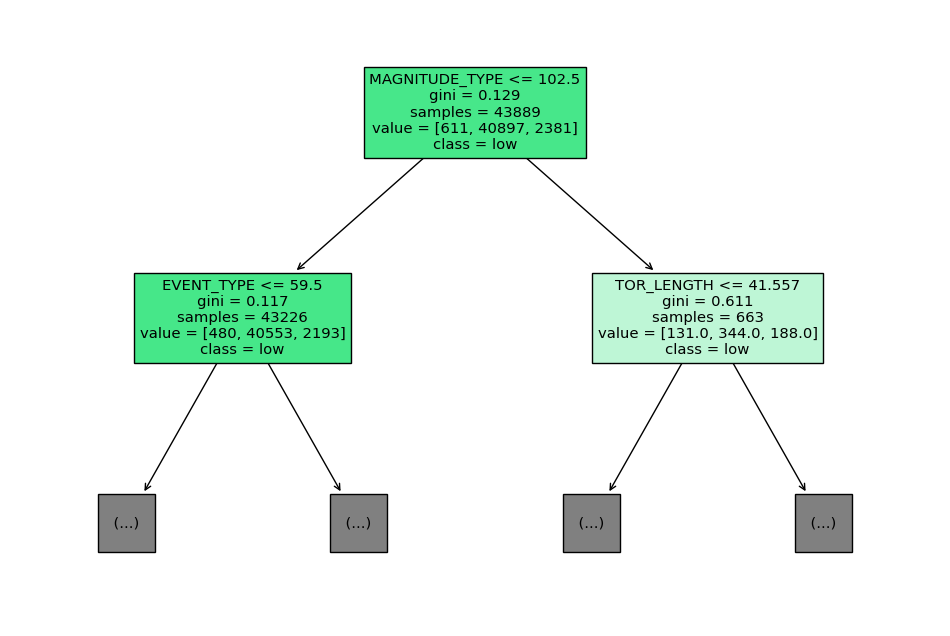

Columns used in the model: ['EVENT_TYPE', 'MAGNITUDE', 'MAGNITUDE_TYPE', 'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'LAT', 'LON', 'ELAPSED_TIME_MIN']


In [14]:
file_path = "StormEvents_details-ftp_v1.0_d2024_c20250401.csv.gz"  # data

df = pd.read_csv(file_path)

### --- FEATURE ENGINEER COLUMNS --- ###

# Drop all rows in which there is no DAMAGE_PROPERTY
df = df[pd.notna(df['DAMAGE_PROPERTY'])]

# Combine BEGIN_LAT and END_LAT into a single LAT column
def combine_latitudes(row):
    if pd.notna(row['BEGIN_LAT']) and pd.notna(row['END_LAT']):
        return (row['BEGIN_LAT'] + row['END_LAT']) / 2 # LAT = Average (both present)
    elif pd.notna(row['BEGIN_LAT']):
        return row['BEGIN_LAT']  # LAT = BEGIN_LAT (END_LAT missing)
    elif pd.notna(row['END_LAT']):
        return row['END_LAT']  # LAT = END_LAT (BEGIN_LAT missing)
    else:
        return np.nan  # Return NaN (both missing)

# Combine BEGIN_LAT and END_LAT into a single LAT column
def combine_longitudes(row):
    if pd.notna(row['BEGIN_LON']) and pd.notna(row['END_LON']):
        return (row['BEGIN_LON'] + row['END_LON']) / 2 # LON = Average (both present)
    elif pd.notna(row['BEGIN_LON']):
        return row['BEGIN_LON']  # LON = BEGIN_LON (END_LON missing)
    elif pd.notna(row['END_LON']):
        return row['END_LON']  # LON = END_LON (BEGIN_LON missing)
    else:
        return np.nan  # Return NaN (both missing)

# Apply the function to create the LAT column
df['LAT'] = df.apply(combine_latitudes, axis=1)
df['LON'] = df.apply(combine_latitudes, axis=1)

def calculate_elapsed_minutes(row):
    # Convert the strings to datetime objects using the correct format
    begin_time = pd.to_datetime(row['BEGIN_DATE_TIME'], format="%d-%b-%y %H:%M:%S", errors='coerce')
    end_time = pd.to_datetime(row['END_DATE_TIME'], format="%d-%b-%y %H:%M:%S", errors='coerce')
    
    # If either conversion fails, return NaN
    if pd.isna(begin_time) or pd.isna(end_time):
        return np.nan

    # Compute the elapsed time in minutes and return as an integer
    elapsed = end_time - begin_time
    return int(elapsed.total_seconds() // 60)

# Create the new column by applying the function
df['ELAPSED_TIME_MIN'] = df.apply(calculate_elapsed_minutes, axis=1)

# Optional: Print out a sample to verify correctness
print(df[['BEGIN_DATE_TIME', 'END_DATE_TIME', 'ELAPSED_TIME_MIN']].head())


# Drop unnecessary columns
df = df.drop(columns=[
    'CZ_TYPE', 'CZ_FIPS', 'EPISODE_ID', 'EVENT_ID', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE',
    'DATA_SOURCE', 'SOURCE', 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
    'DEATHS_INDIRECT', 'FLOOD_CAUSE', 'MONTH_NAME', 'BEGIN_DAY', 'BEGIN_TIME', 'END_DAY', 'END_TIME',
    'CZ_NAME', 'WFO', 'CZ_TIMEZONE', 'BEGIN_RANGE', 'BEGIN_DATE_TIME', 'END_DATE_TIME',
    'TOR_OTHER_CZ_NAME', 'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_WFO',
    'END_RANGE', 'BEGIN_AZIMUTH', 'END_AZIMUTH', 'BEGIN_LON', 'END_LON', 'BEGIN_LAT', 'END_LAT', 'BEGIN_LOCATION', 'END_LOCATION',
    'BEGIN_YEARMONTH', 'END_YEARMONTH', 'STATE', 'STATE_FIPS', 'YEAR', 'CATEGORY'
])

def convert_damage(value):
    if pd.isna(value):
        return 0  # Handle NaN values
    value = str(value).upper().strip()  # Ensure the value is uppercase and clean
    if value.endswith('K'):  # Thousands
        try:
            return float(value[:-1]) * 1e3
        except ValueError:
            return 0
    # Optionally, handle other cases (e.g., values ending in 'M' for millions)
    try:
        return float(value)
    except ValueError:
        return 0

df['DAMAGE_PROPERTY'] = df['DAMAGE_PROPERTY'].apply(convert_damage)
df['DAMAGE_CROPS'] = df['DAMAGE_CROPS'].apply(convert_damage)

# Make sure DAMAGE_PROPERTY is numeric
df['DAMAGE_PROPERTY'] = pd.to_numeric(df['DAMAGE_PROPERTY'], errors='coerce')

# Create the damage category using pd.cut; include the lowest value in the first bin.
bins = [0, 10000, 100000, np.inf]
labels = ['low', 'medium', 'high']
df['DAMAGE_CATEGORY'] = pd.cut(df['DAMAGE_PROPERTY'], bins=bins, labels=labels, include_lowest=True)

# Impute missing values in the numeric columns of the dataframe
numeric_columns = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

# Create X and y after imputing missing values
X = df[numeric_columns].drop(columns=['DAMAGE_PROPERTY', 'DAMAGE_CROPS'])
# Although you already imputed missing values above, we'll use the imputer once more to ensure no NaNs remain in X.
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)
y = df['DAMAGE_CATEGORY'].values

# Check for NaN values in X
print("NaNs in X after imputation:", np.isnan(X).any())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for NaN values in X_train and X_test
print("NaNs in X_train:", np.isnan(X_train).any())
print("NaNs in X_test:", np.isnan(X_test).any())

# Train the classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Visualize the decision tree
plt.figure(figsize=(12, 8))
# When plotting the tree, exclude the columns used for DAMAGE_PROPERTY, DAMAGE_CROPS, DAMAGE_CATEGORY
feature_names = df.drop(columns=['DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'DAMAGE_CATEGORY']).columns
plot_tree(clf, feature_names=feature_names, class_names=clf.classes_, filled=True, max_depth=1)
plt.show()

print("Columns used in the model:", list(feature_names))



# Feature Engineering


# Clustering

# Most association with different features